In [1]:
import matplotlib.pyplot as plt
from torch.utils import data
import numpy as np
from tqdm import tqdm
import random
from functions import to_price_paths
from visualisationMetrics import *
from dataLoader import *
from utils.utils import plot_2axes
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from collections import defaultdict

### Step 1: Load real data

In [2]:
real_data = load_dataset(data_mode='Train')
real_dataloader = data.DataLoader(real_data, batch_size=1, num_workers=1, shuffle=True)
print(f"gen ~ N({real_data.Y.mean()}, {real_data.Y_test.var(axis=-1).mean()})")

[*********************100%%**********************]  1 of 1 completed


X_train's shape is (4328, 1, 1, 2), X_test's shape is (481, 1, 1, 2)
y_train's label shape is (4328, 1, 1, 43), y_test's label shape is (481, 1, 1, 43)
gen ~ N(1.0090950727462769, 0.000880711420904845)


In [3]:
real_paths = []
real_conds = []

for i, (cond, sim) in enumerate(real_dataloader):
    sim = sim.cpu().detach().numpy()
    sim = sim.reshape(sim.shape[1], sim.shape[3])
    real_paths.append(sim)
    cond = cond.cpu().detach().numpy()
    cond = cond.reshape(cond.shape[1], cond.shape[3])
    real_conds.append(cond)

real_paths = np.array(real_paths)
real_conds = np.array(real_conds)
print(real_paths.shape)
print(real_conds.shape)

(481, 1, 43)
(481, 1, 2)


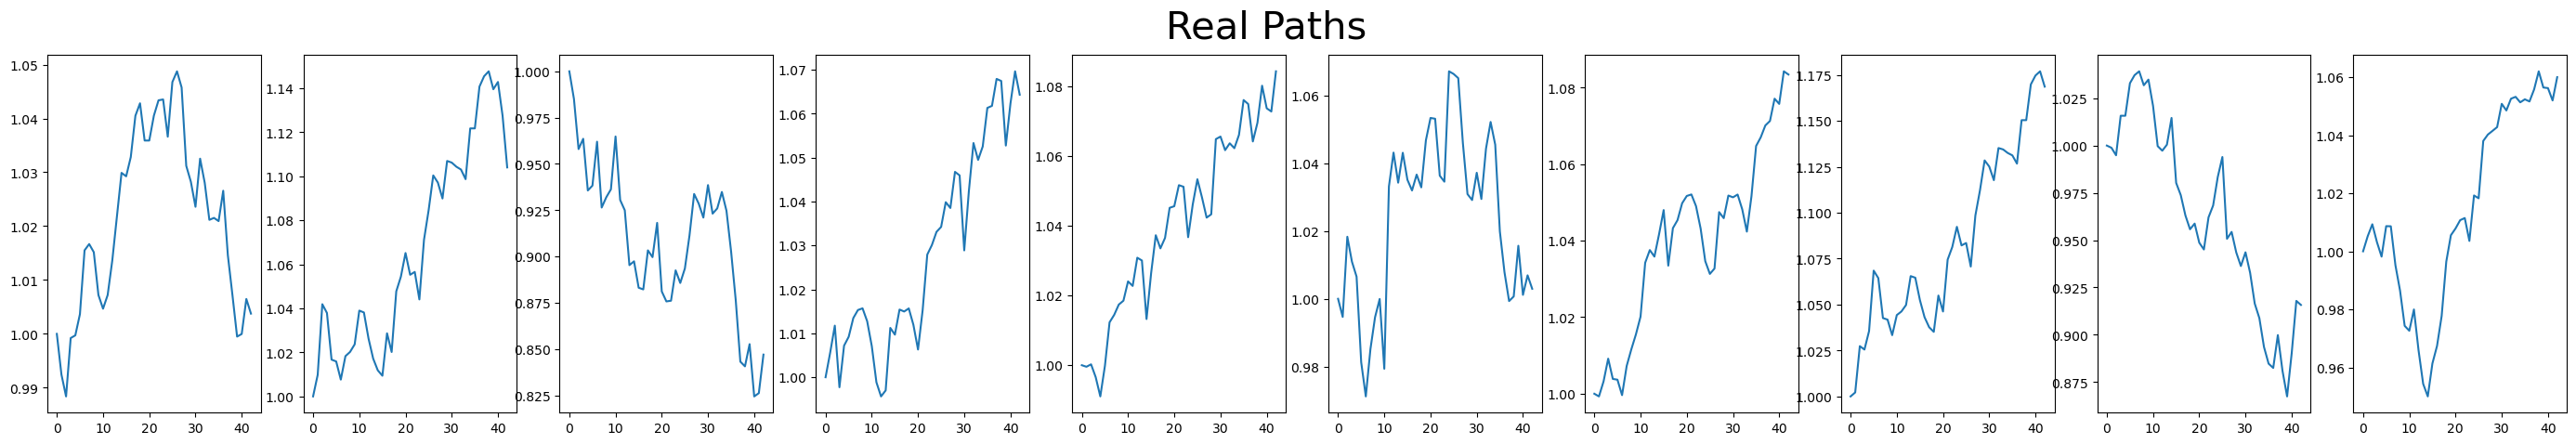

In [4]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Real Paths', fontsize=30)
for i in range(10):
    for path in real_paths[i]:
        axs[i].plot(path[:])

### Step 2: Load synthetic data

In [5]:
from LoadSynthetic import *

In [26]:
syn_data = Synthetic_Dataset(model_path='./logs/latest/Model/checkpoint', dataset=real_data, seq_len=real_data.output_size, conditions_dim=real_data.X_train.shape[-1])
syn_dataloader = data.DataLoader(syn_data, batch_size=1, num_workers=1, shuffle=True)

In [27]:
syn_paths = []
syn_conds = []

for i, (cond, sim) in enumerate(syn_dataloader):
    sim = sim.cpu().detach().numpy()
    sim = sim.reshape(sim.shape[1], sim.shape[3])
    syn_paths.append(sim)
    cond = cond.cpu().detach().numpy()
    cond = cond.reshape(cond.shape[1], cond.shape[3])
    syn_conds.append(cond)
    
syn_paths = np.array(syn_paths)
syn_conds = np.array(syn_conds)
print(syn_paths.shape)
print(syn_conds.shape)

(481, 1, 43)
(481, 1, 2)


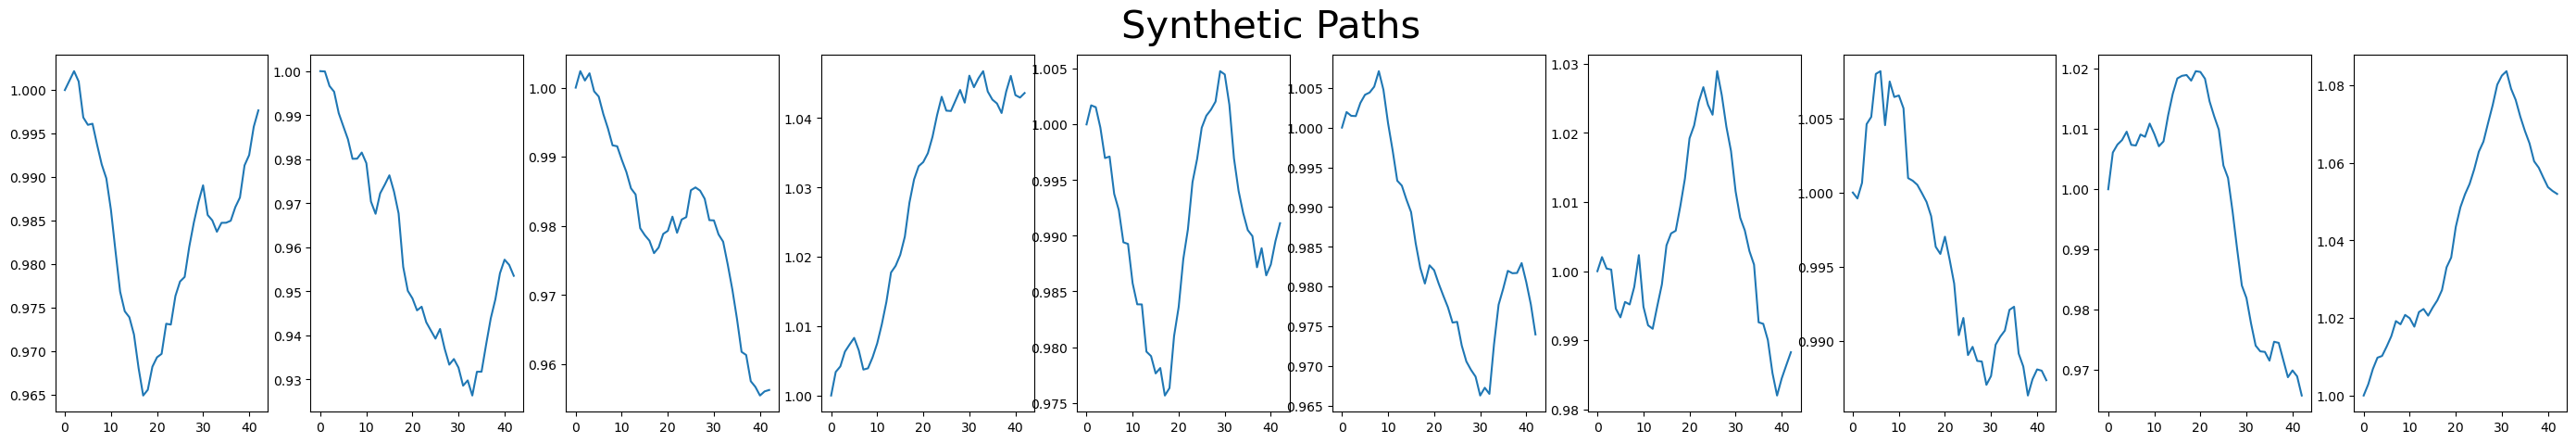

In [28]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('Synthetic Paths', fontsize=30)
for i in range(10):
    for path in syn_paths[i]:
        axs[i].plot(path[:])

### Step 3: Load benchmark data

In [9]:
class GBM_Simulator:
    def __init__(self, dataset, nsamples=10):
        self.dataset = dataset
        self.ivol = dataset.df.ivol[1:] / np.sqrt(252) / 100
        self.rates = dataset.df.rates / np.sqrt(252)
        self.window = dataset.output_size
        self.train_size = len(dataset.Y_train)
        self.test_size = len(dataset.Y_test)
        self.nsamples = nsamples
    
    def _empirical_martingale_correction(self, paths, r):
        """
        paths: 2d array/list of dimensions nsamples * nsteps
        r:     risk-free rate
        """
        old_paths = paths.copy()
        for j in range(1, paths.shape[1]):
            Zj = paths[:, j-1] * paths[:, j] / old_paths[:, j-1]
            Z0 = 1/len(paths) * np.exp(-r/252*j) * Zj.sum()
            paths[:, j] = paths[0][0] * Zj / Z0
        return paths
    
    def _simulate(self, mu=0, var=0.1, s0=1, nsamples=10, nsteps=100, EMS=True):
        """
        Returns sample_paths, an np.array() of dimensions (nsamples * nsteps)
        """
        # For each sample
        init_path = np.zeros(nsteps + 1)
        init_path[0] = s0
        sample_paths = np.array([init_path for _ in range(nsamples)]) # nsamples * (nsteps+1)
        
        # Adjust drift terms
        nu = mu - var/2
        std = np.sqrt(var)
        # For each sample
        for nsample in range(0, nsamples, 2):
            for nstep in range(nsteps):
                # Generate correlated random variables
                z = np.random.randn()
                # Get normal & antithetic steps
                step = nu + z*std
                antithetic_step = nu - z*std
                # Update the paths
                sample_paths[nsample, nstep+1] = sample_paths[nsample, nstep] * np.exp(step)
                if nsample+1<nsamples: sample_paths[nsample+1, nstep+1] = sample_paths[nsample+1, nstep] * np.exp(antithetic_step)
        # Empirical martingale correction
        if EMS: sample_paths = self._empirical_martingale_correction(sample_paths, r=mu)
        return sample_paths

    def _calibrate(self, logreturns):
        # Get drift
        mu = logreturns.mean()
        # Get diffusion
        var = logreturns.var()
        return mu, var
    
    def run(self, risk_neutral=True, EMS=True):
        simulations = np.zeros((self.test_size, self.nsamples, self.window+1))
        # For each window
        for i in tqdm(range(self.test_size-1), position=0, leave=True):
            var = self.ivol.iloc[i] ** 2
            mu = self.rates.iloc[i]
            # For each sample
            simulations[i,:,:] = self._simulate(mu, var, nsamples=self.nsamples, nsteps=self.window, EMS=EMS)
        return simulations
    
    def get_sims(self, date, n=100):
        ivol = self.ivol.loc[date]
        return self._simulate(mu=0, var=ivol**2, nsamples=n, nsteps=self.window, EMS=True)

In [10]:
simulator = GBM_Simulator(dataset=real_data)
gbm_paths = simulator.run()
gbm_paths = np.reshape(gbm_paths, (-1,1,gbm_paths.shape[-1]))

print(gbm_paths.shape)

100%|██████████| 480/480 [00:00<00:00, 709.18it/s]

(4810, 1, 43)


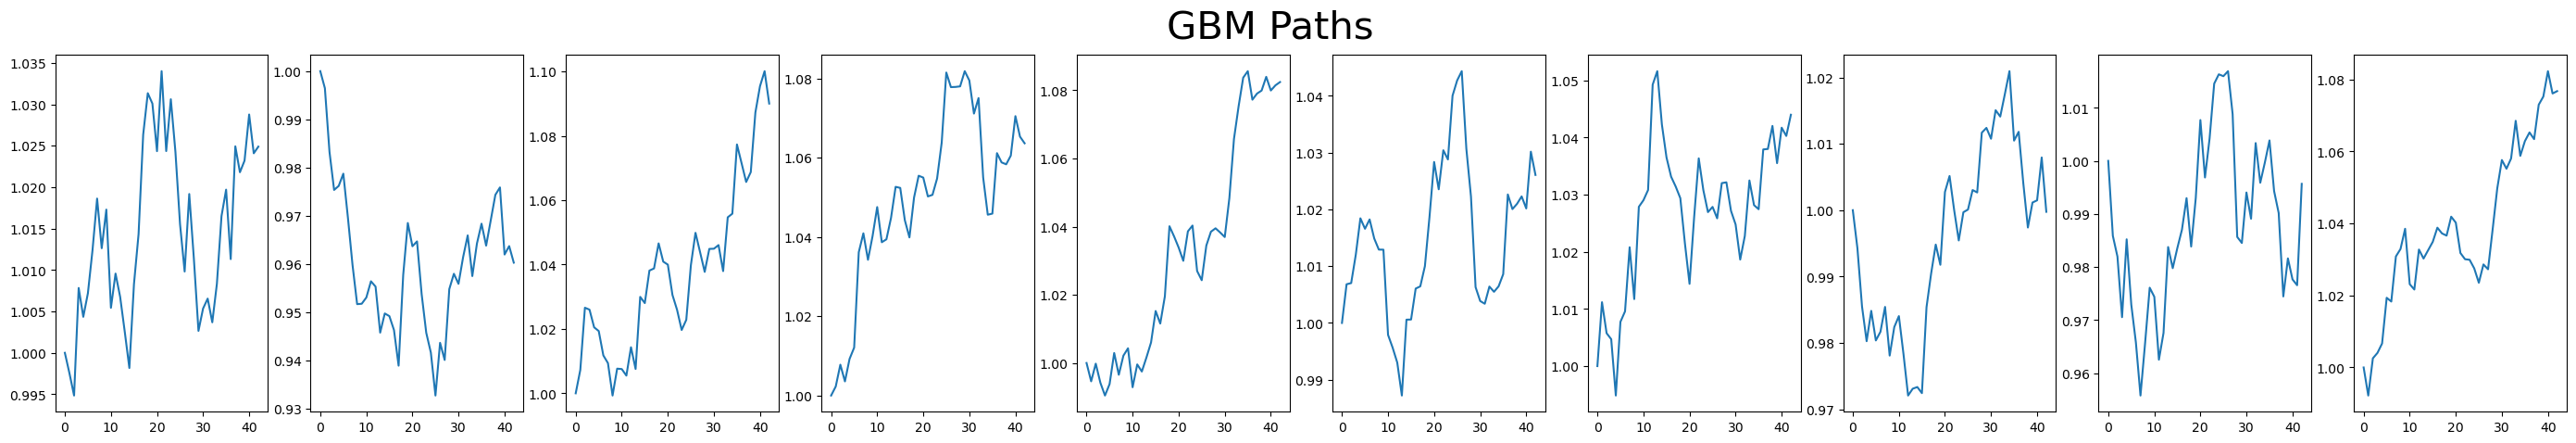

In [11]:
fig, axs = plt.subplots(1, 10, figsize=(35,5))
fig.suptitle('GBM Paths', fontsize=30)
samples = random.sample(range(len(gbm_paths)),k=10)
for i in range(10):
    for sim in gbm_paths[samples[i]]:
        axs[i].plot(sim[:])

### Dimensionality Reduction

In [29]:
real_vals = np.transpose(real_paths, (0,2,1)) #np.concatenate((real_conds, real_paths), axis=-1), (0,2,1))
syn_vals = np.transpose(syn_paths, (0,2,1)) #np.concatenate((syn_conds, syn_paths), axis=-1), (0,2,1))
np.random.shuffle(syn_vals)
gbm_vals = np.transpose(gbm_paths, (0, 2, 1))
np.random.shuffle(gbm_vals)

print(real_vals.shape)
print(syn_vals.shape)
print(gbm_vals.shape)

(481, 43, 1)
(481, 43, 1)
(4810, 43, 1)


In [30]:
visualization([real_vals, syn_vals, gbm_vals], ['Real', 'Synthetic', 'Benchmark (GBM)'], 'pca', 'test')

In [31]:
visualization([real_vals, syn_vals, gbm_vals], ['Real', 'Synthetic', 'Benchmark (GBM)'], 'tsne', 'test')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1443 samples in 0.001s...
[t-SNE] Computed neighbors for 1443 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1443
[t-SNE] Computed conditional probabilities for sample 1443 / 1443
[t-SNE] Mean sigma: 0.041976
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.800457
[t-SNE] KL divergence after 300 iterations: 1.231750


### Compute JS divergence

In [32]:
print(real_vals.min(), real_vals.max())
print(syn_vals.min(), syn_vals.max())
print(gbm_vals.min(), gbm_vals.max())

0.82385844 1.177025
0.8507767 1.1749038
0.0 1.2473818674481552


In [33]:
n_components = 10
real_pca, syn_pca, gbm_pca = dim_reduction([real_vals, syn_vals, gbm_vals], n_components=n_components, mode='pca')
real_tsne, syn_tsne, gbm_tsne = dim_reduction([real_vals, syn_vals, gbm_vals], n_components=n_components, mode='tsne')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1443 samples in 0.001s...
[t-SNE] Computed neighbors for 1443 samples in 0.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1443
[t-SNE] Computed conditional probabilities for sample 1443 / 1443
[t-SNE] Mean sigma: 0.041976
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.800388
[t-SNE] KL divergence after 300 iterations: 1.231889


In [34]:
from scipy.stats import gaussian_kde
from scipy.integrate import nquad

# Define a function to compute the KL divergence
def kl_divergence(pdf1, pdf2):
    # Sample
    samples = pdf1.resample(size=10_000)
    pdf1_values = pdf1(samples)
    pdf2_values = pdf2(samples)
    # Compute the log ratio of the PDF values, avoid division by zero
    with np.errstate(divide='ignore'):
        log_ratios = np.log(pdf1_values/pdf2_values)
    # Compute the Monte Carlo estimate of the KL divergence
    log_ratios = log_ratios[~(np.isnan(log_ratios)|np.isinf(log_ratios))]
    return np.mean(log_ratios)

def js_divergence(data1, data2, verbose=True, bw_method=None, **kwargs):
    data1 = data1.reshape((-1,data1.shape[0]))
    data2 = data2.reshape((-1,data2.shape[0]))
    data1 = data1[:, ~np.any(np.isnan(data1)|np.isinf(data1), axis=0)]
    data2 = data2[:, ~np.any(np.isnan(data2)|np.isinf(data2), axis=0)]

    min_len = min(data1.shape[1], data2.shape[1])
    np.random.shuffle(data1)
    np.random.shuffle(data2)
    data1 = data1[:, :min_len]
    data2 = data2[:, :min_len]
    pdf1 = gaussian_kde(data1, bw_method=bw_method)
    pdf2 = gaussian_kde(data2, bw_method=bw_method)

    kl1 = kl_divergence(pdf1, pdf2, **kwargs)
    if verbose: print(f"KL(data1||data2) = {kl1}")
    kl2 = kl_divergence(pdf2, pdf1, **kwargs)
    if verbose: print(f"KL(data2||data1) = {kl2}")
    return (kl1+kl2)/2

In [35]:
divergence = js_divergence(real_pca, syn_pca)
print(divergence)
divergence = js_divergence(real_pca, gbm_pca)
print(divergence)

print()

divergence = js_divergence(real_tsne, syn_tsne)
print(divergence)
divergence = js_divergence(real_tsne, gbm_tsne)
print(divergence)

KL(data1||data2) = 5.49247298792136
KL(data2||data1) = 1.9259544944295037
3.709213741175432
KL(data1||data2) = 4.140819899822556
KL(data2||data1) = 1.3072330614631824
2.724026480642869

KL(data1||data2) = 0.4179202779640101
KL(data2||data1) = 0.3234496275007879
0.370684952732399
KL(data1||data2) = 0.40597069313493417
KL(data2||data1) = 0.2095740897417362
0.3077723914383352


### Compute FID score

In [36]:
from scipy.linalg import sqrtm

def fid(data1, data2):
    data1 = data1.reshape((data1.shape[0], -1))
    data2 = data2.reshape((data2.shape[0], -1))
    # calculate mean and covariance statistics
    mu1, sigma1 = data1.mean(axis=0), np.cov(data1, rowvar=False)
    mu2, sigma2 = data1.mean(axis=0), np.cov(data2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = 0.5 * (sqrtm(sigma1.dot(sigma2)) + sqrtm(sigma2.dot(sigma1)))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

In [37]:
fid(real_vals, syn_vals)

0.018083499500949684

In [38]:
fid(real_vals, gbm_vals)

0.015530363133751376

### Simulate given conditions

In [39]:
df = real_data.df
simulator = GBM_Simulator(dataset=real_data)

def generate_paths(date, n=500, mode='syn'):
    paths = None
    if mode=='syn':
        paths = syn_data.get_sims(date, n=n)
        paths = np.array(paths).reshape(paths.shape[0], paths.shape[-1])
    elif mode=='gbm':
        paths = simulator.get_sims(date, n=n)
    else:
        raise NotImplementedError
    paths = paths * df.loc[date]['close']
    return paths

def plot_sims(dates, mode, n=50, error_bars=True, output_size=real_data.output_size):
    assert output_size <= real_data.output_size
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    info = defaultdict(list)
    for date in dates:
        syn_paths = generate_paths(date, n=n, mode=mode)[:,:output_size]
        sim_dates = df.loc[date:].index[:output_size]
        if len(sim_dates)<syn_paths.shape[-1]: 
            sim_dates = pd.date_range(date, periods=output_size+1, freq='B')
        for i, path in enumerate(syn_paths):
            fig.add_trace(go.Scatter(
                x=sim_dates, y=path,
                mode='lines',
                name=f'{date} simulations',
                legendgroup=f'simulations',
                showlegend=i==0,
            ), secondary_y=True,)
        info['s0'].append(syn_paths[0,0])
        info['start_dates'].append(sim_dates[0])
        info['end_dates'].append(sim_dates[-1])
        info['means'].append(syn_paths[:,-1].mean())
        info['stds'].append(syn_paths[:,-1].std(ddof=1))

    # Plot mean & std
    if error_bars:
        fig.add_trace(go.Scatter(
            x=info['end_dates'],
            y=info['means'],
            mode='markers',
            error_y=dict(
                type='data',
                array=info['stds'],
                visible=True
            ),
            line=dict(color="Brown"),
            showlegend=False,
        ), secondary_y=True,)
        fig.add_trace(go.Scatter(
            x=info['start_dates'],
            y=info['s0'],
            mode='markers',
            line=dict(color="Brown"),
            showlegend=False,
        ), secondary_y=True,)
        for i in range(len(dates)):
            fig.add_trace(go.Scatter(
                x=[info['start_dates'][i], info['end_dates'][i]],
                y=[info['s0'][i], info['means'][i]],
                mode='lines',
                line=dict(color="Brown"),
                showlegend=False,
            ), secondary_y=True,)
            
    fig.add_trace(
        go.Scatter(x=df.index, y=df['close'], name='close', line=dict(color="Black")),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df['ivol'], name='ivol', line=dict(color="Gray")),
        secondary_y=False, 
    )

    fig.add_vline(x=real_data.test_start_date, line_dash="dash")
    fig.add_annotation(x=real_data.test_start_date, y=10, text='Test start date', showarrow=False)

    # Set y-axes titles
    fig.update_yaxes(title_text='ivol', secondary_y=False)
    fig.update_yaxes(title_text='close', secondary_y=True)
    fig.show()

In [40]:
dates = df.loc[real_data.test_start_date:].index
dates = dates[(np.array(range(len(dates))))%10==0]
n = 10

In [41]:
plot_sims(dates, mode='syn', n=n)

In [102]:
plot_sims(dates, mode='syn', n=n)

In [101]:
plot_sims(dates, mode='gbm', n=n)

### Runtime

In [108]:
for i in tqdm(range(1000)):
    _ = generate_paths('2022-03-07', n=100, mode='syn').shape

100%|██████████| 1000/1000 [00:44<00:00, 22.71it/s]


In [110]:
for i in tqdm(range(1000)):
    _ = generate_paths('2022-03-07', n=100, mode='gbm').shape

100%|██████████| 1000/1000 [00:04<00:00, 200.36it/s]
